In [156]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [157]:
from cptsolver.fields import *
from cptsolver.utils import *
from cptsolver.plot import *
from cptsolver.integrators import *
from cptsolver.solver import *
from cptsolver.analyzer import *
from cptsolver.young import *

from matplotlib import pyplot as plt

from datetime import datetime

We begin by grabbing the Tsyganenko model parameters from the dataset developed by Qin et al. (2007).

In [158]:
year = 2008
month = 3
day = 26
hour = 11
minute = 19

time = datetime(year, month, day, hour, minute)
parmod, ut, v_sw = get_txx_params('data/qindenton_03-26-2008', 'data/omni_03-26-2008', time)
b_field = t04(parmod, ut, v_sw)

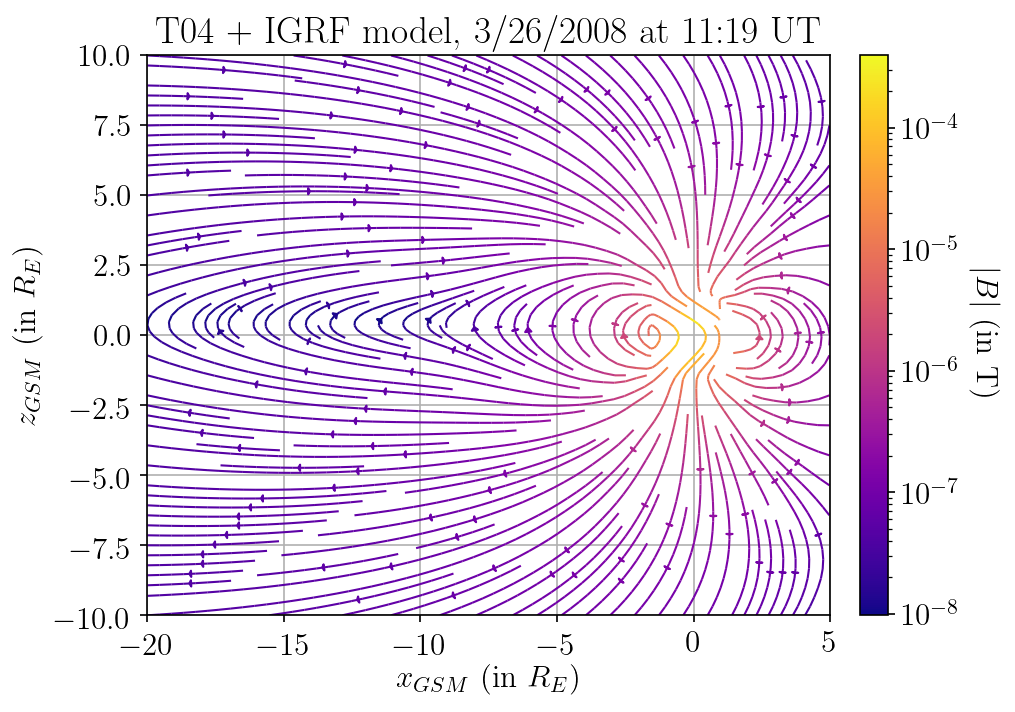

In [159]:
format_plots()
plot_field(b_field, np.array([1., 0., 0.]), np.array([0., 0., 1.]), [-20, 5], [-10, 10], size=(7, 5), labels=('$x_{GSM}$ (in $R_E$)', '$z_{GSM}$ (in $R_E$)', '$|B|$ (in T)'), title=f'T04 + IGRF model, {month}/{day}/{year} at {hour}:{minute} UT')

We next trace a field line at the specificed $L$ value along the midnight plane. After determining $\mathbf{B}$ along the field line, we calculate the $B_{\text{mirror}}$ and $B_0$.

In [160]:
L = 10

rr = field_line(b_field, np.array([-L * Re, 0., 0.]))
bv, bm, brm = b_along_path(b_field, rr)
cs_ind = bm.argmin()

b_mirror_south = bm[np.abs(np.linalg.norm(rr[0:cs_ind], axis=1) - (Re + 100e3)).argmin()]
b_mirror_north = bm[np.abs(np.linalg.norm(rr[cs_ind:], axis=1) - (Re + 100e3)).argmin() + cs_ind]

b0 = bm[cs_ind]
b_mirror = min(b_mirror_north, b_mirror_south)

eq_loss_cone_ang = np.arcsin(np.sqrt(bm[cs_ind] / b_mirror))
print(f'The equatorial loss cone angle is {np.degrees(eq_loss_cone_angle):.3f} degrees.')

The equatorial loss cone angle is 0.701 degrees.


We can compare the normalized bounce time between the Tsyganenko model and the usual expression valid in a dipole field.

In [161]:
T_alpha = normalized_bounce_time(b_field, 10)

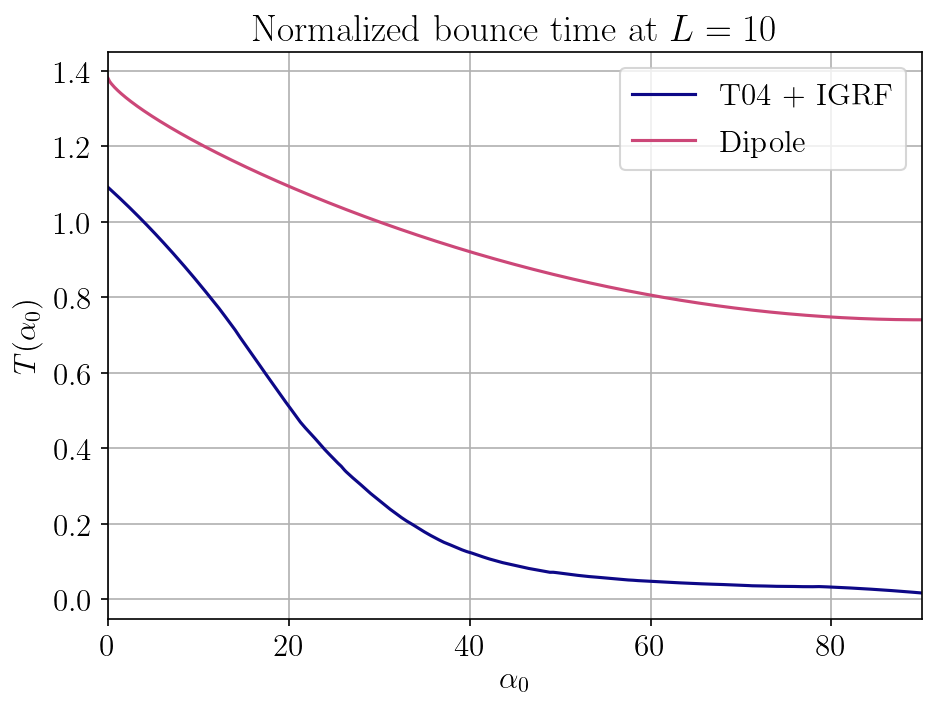

In [162]:
plt.figure(figsize=(7, 5))

alpha_eqs = np.radians(np.linspace(0, 90, 500))
plt.plot(np.degrees(alpha_eqs), T_alpha(alpha_eqs), label='T04 + IGRF')
plt.plot(np.degrees(alpha_eqs), T_dipole(alpha_eqs), label='Dipole', c='C7')

plt.xlim([0, 90])
plt.xlabel(r'$\alpha_0$')
plt.ylabel(r'$T(\alpha_0)$')
plt.title('Normalized bounce time at $L = 10$')

plt.legend()
plt.grid()
plt.show()

By guessing at the current sheet thickness $L_{cs}$, we generate the Harris model corresponding to the above Tsyganenko model.

In [163]:
L_cs_guess = 0.5 * Re

b0x, sigma, L_cs = harris_params_from_txx(b_field, 10, L_cs_guess)
b_field_h = harris_cs_model(b0x, sigma, L_cs)

We can then examinen the properties of this model and compare them to the Tsyganenko.

In [164]:
zsT = (rr[:, 2] - rr[cs_ind, 2]) / Re
flcT = np.zeros(len(bm))

for i in range(len(flcT)):
    flcT[i] = flc(b_field, rr[i], eps=10) / Re
    
N = 200
zs = np.linspace(-2, 2, N)

bm0 = np.zeros(N)
bm1 = np.zeros(N)

flc0 = np.zeros(N)
flc1 = np.zeros(N)

for i in range(N):
    bm0[i] = np.linalg.norm(b_field_h(np.array([0., 0., zs[i] * Re])))
    flc0[i] = flc(b_field_h, np.array([0., 0., zs[i] * Re]), eps=10) / Re
    
bh_v = np.zeros((300, 3))
zs_h = np.linspace(-2, 2, 300)

for i in range(300):
    bh_v[i] = b_field_h(np.array([0., 0., zs_h[i] * Re]))

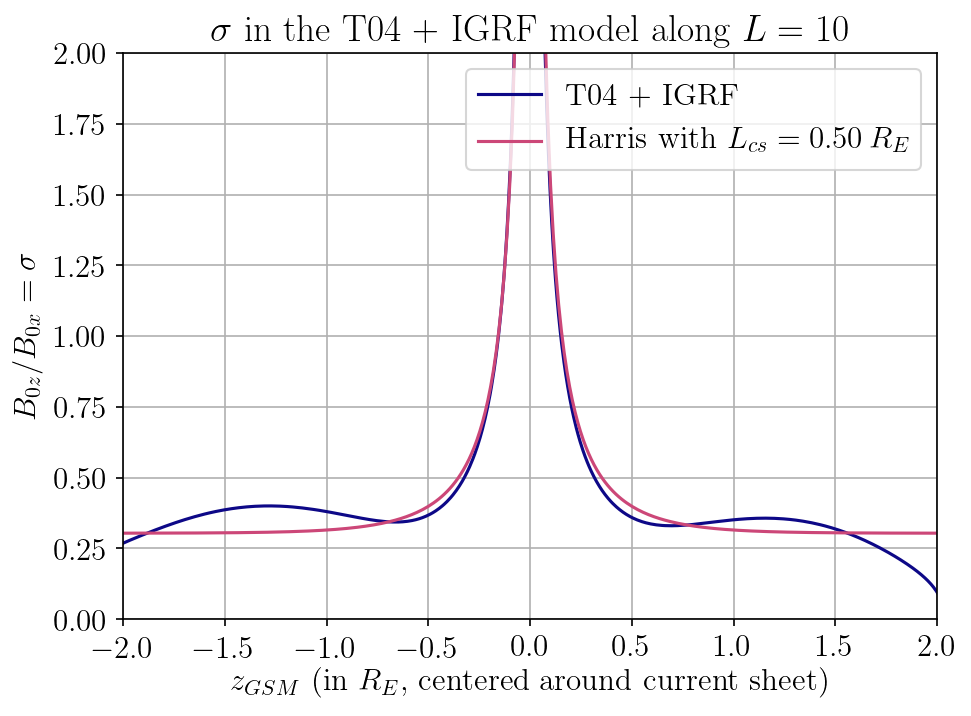

In [165]:
pad = 480
plt.figure(figsize=(7, 5))

plt.plot((rr[:, 2][pad:-pad] - rr[cs_ind, 2]) / Re, np.abs(bv[:, 2][pad:-pad] / bv[:, 0][pad:-pad]), label='T04 + IGRF')
plt.plot(zs_h, np.abs(bh_v[:, 2] / bh_v[:, 0]), c='C7', label=f'Harris with $L_{{cs}}={L_cs / Re:.2f}\,R_E$')

plt.xlim([-2, 2])
plt.xlabel('$z_{GSM}$ (in $R_E$, centered around current sheet)')
plt.ylim([0, 2])
plt.ylabel(r'$B_{0z}/B_{0x} = \sigma$')
plt.title(f'$\sigma$ in the T04 + IGRF model along $L = {L}$')

plt.legend()
plt.grid()
plt.show()

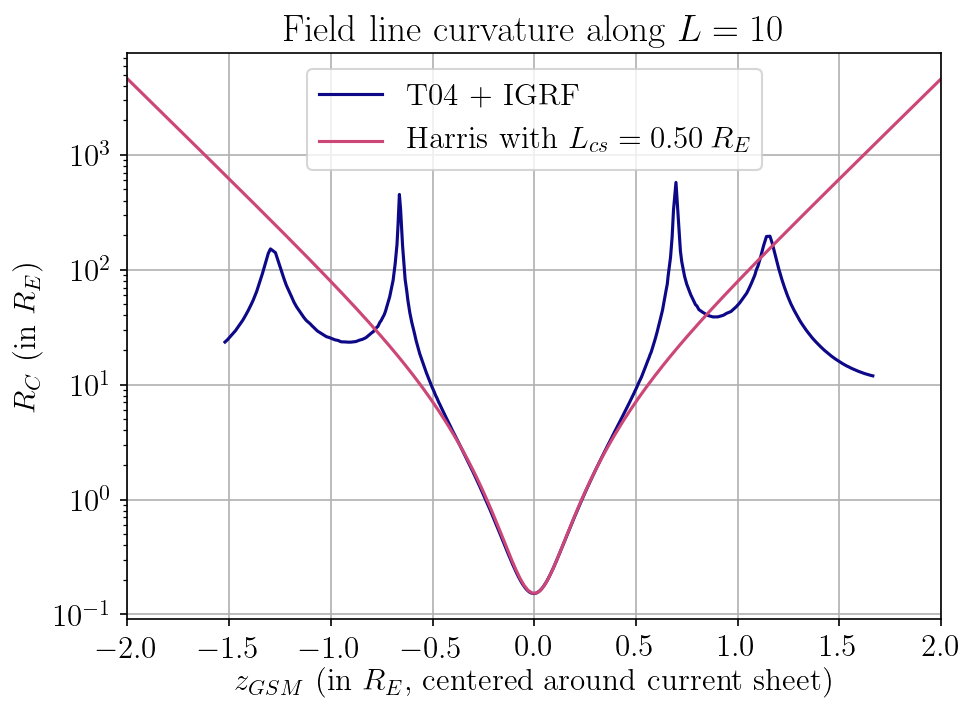

In [166]:
format_plots()
plt.figure(figsize=(7, 5))

plt.semilogy(zsT[cs_ind-200:cs_ind+200], flcT[cs_ind-200:cs_ind+200], label=r'T04 + IGRF', c='C0')    
plt.semilogy(zs, flc0, label=f'Harris with $L_{{cs}}={L_cs / Re:.2f}\,R_E$', c='C7')

plt.xlim([-2, 2])
plt.xlabel('$z_{GSM}$ (in $R_E$, centered around current sheet)')
plt.ylabel('$R_C$ (in $R_E$)')
plt.title(f'Field line curvature along $L={L}$')

plt.legend()
plt.grid()
plt.show()

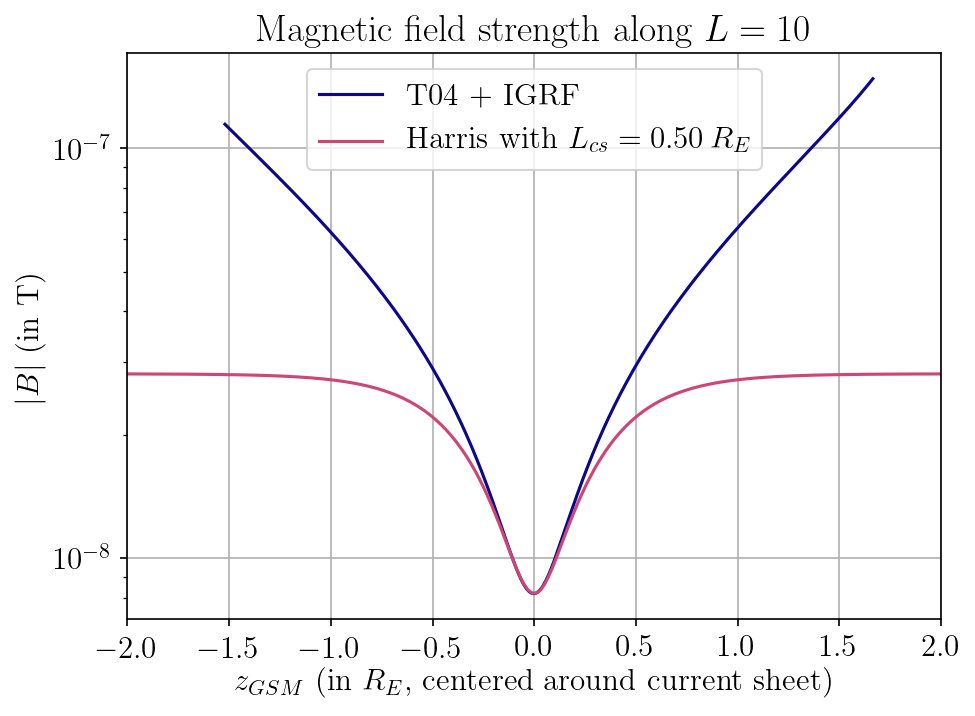

In [167]:
format_plots()
plt.figure(figsize=(7, 5))

plt.semilogy(zsT[cs_ind-200:cs_ind+200], bm[cs_ind-200:cs_ind+200], label=r'T04 + IGRF', c='C0')
plt.semilogy(zs, bm0, label=f'Harris with $L_{{cs}}={L_cs / Re:.2f}\,R_E$', c='C7')

plt.xlim([-2, 2])
plt.xlabel('$z_{GSM}$ (in $R_E$, centered around current sheet)')
plt.ylabel('$|B|$ (in T)')
plt.title(f'Magnetic field strength along $L={L}$')

plt.legend()
plt.grid()
plt.show()

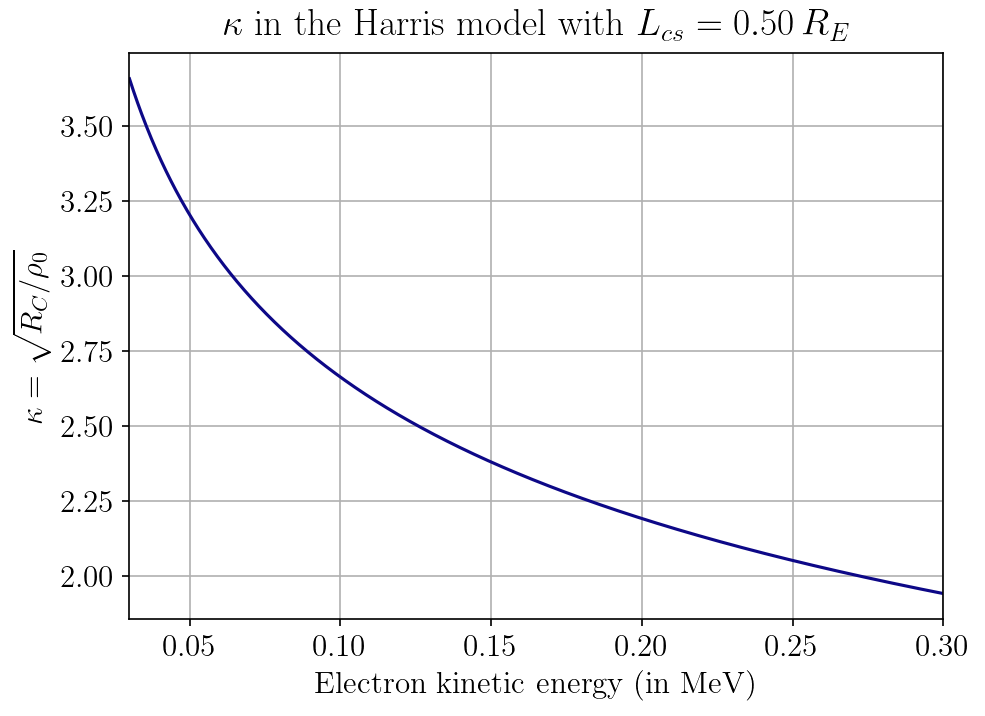

In [184]:
energies = np.linspace(30e3, 300e3, 1000)

def kappa_h(E):
    gamma = eV_to_J(E) / (sp.m_e * sp.c**2) + 1
    v = sp.c * np.sqrt(1 - 1 / gamma**2)
    return np.sqrt(np.abs(-sp.e) * sigma**2 * L_cs * b0x / (gamma * sp.m_e * v))

plt.figure(figsize=(7, 5))

plt.plot(energies * 1e-6, kappa_h(energies), c='C0')

plt.xlim([3e-2, 3e-1])
plt.xlabel('Electron kinetic energy (in MeV)')
plt.ylabel(r'$\kappa = \sqrt{R_C/ \rho_0}$')
plt.title(f'$\kappa$ in the Harris model with $L_{{cs}} = {L_cs / Re:.2f}\,R_E$')

plt.grid()
plt.show()

Using the methods of Young et al. (2002) and Young et al. (2008), we may plot the bounce-averaged equatorial pitch angle diffusion coefficient $\langle D_{\alpha_0\alpha_0}\rangle$. We may then estimate the particle lifetime using $\tau = 1/\langle D_{\alpha_0\alpha_0}(\alpha_{LC})\rangle$.

Approximate lifetime of 30 keV particles: 2.40e+10 s
Approximate lifetime of 100 keV particles: 3.58e+08 s
Approximate lifetime of 200 keV particles: 2.83e+05 s
Approximate lifetime of 300 keV particles: 3.97e+04 s


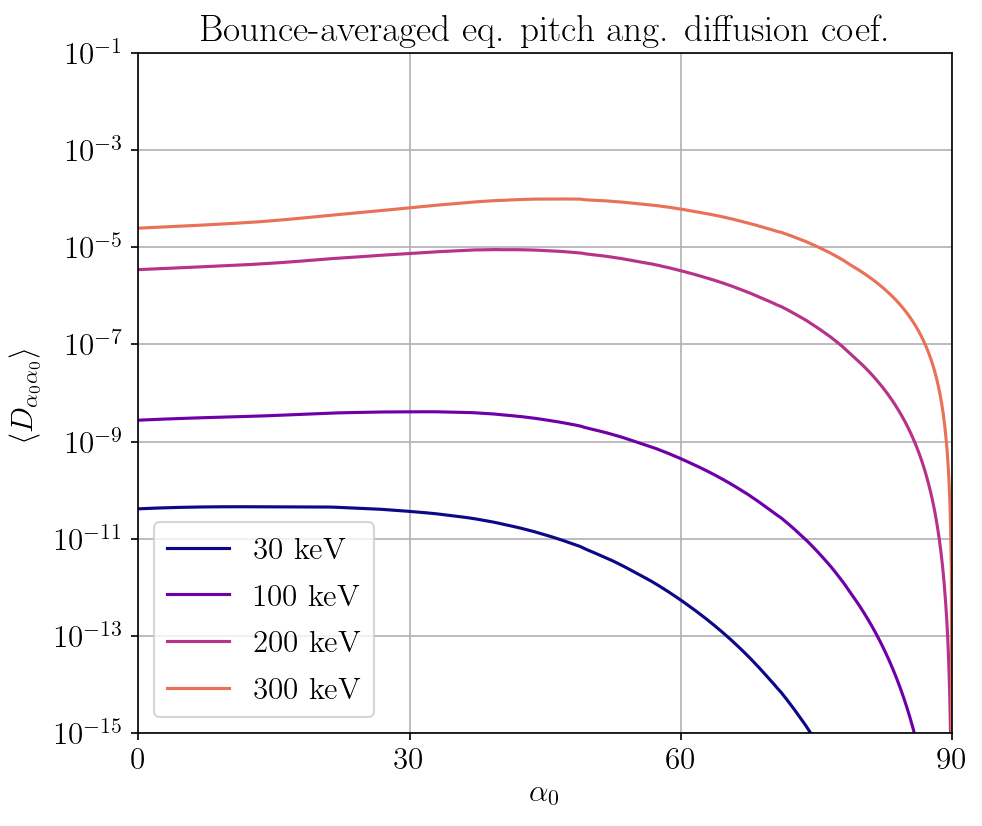

In [177]:
Es = [30, 100, 200, 300]
z1, z2 = zetas_harris(sigma)

steps = 1000
alpha_eqs = np.radians(np.linspace(1e-5, 90 - 1e-5, steps))

plt.figure(figsize=(7, 6))

for i in range(len(Es)):
    eps = epsilon_harris(Es[i] * 1e3, -sp.e, sp.m_e, b0x, sigma, L_cs)
    D_aas = D_aa(eps, z1, z2, alpha_eqs, T_alpha)
    lifetime = 1 / D_aa(eps, z1, z2, eq_loss_cone_ang, T_alpha)
    print(f'Approximate lifetime of {Es[i]} keV particles: {lifetime:.2e} s')
    plt.semilogy(np.degrees(alpha_eqs), D_aas, c=f'C{3*i}', label=f'${Es[i]}$ keV')

plt.xlim([0, 90])
plt.xticks(np.linspace(0, 90, 4))
plt.xlabel(r'$\alpha_0$')
plt.ylim([1e-15, 1e-1])
plt.ylabel(r'$\langle D_{\alpha_0\alpha_0}\rangle$')
plt.title('Bounce-averaged eq. pitch ang. diffusion coef.')

plt.legend()
plt.grid()
plt.show()

Approximate lifetime of 30 keV particles: 5.09e+07 s
Approximate lifetime of 100 keV particles: 1.08e+04 s
Approximate lifetime of 200 keV particles: 5.73e+02 s
Approximate lifetime of 300 keV particles: 1.62e+02 s


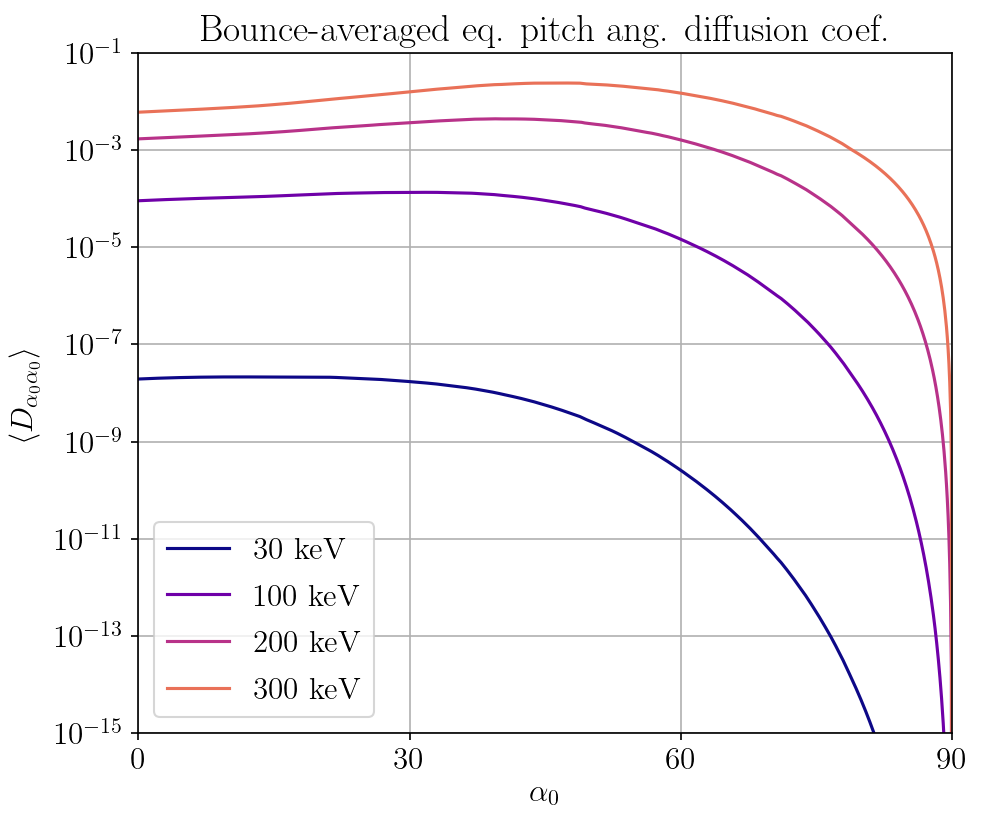

In [185]:
Es = [30, 100, 200, 300]
z1, z2 = zetas_general(b_field, L)
R_c = flc(b_field, rr[cs_ind])

steps = 1000
alpha_eqs = np.radians(np.linspace(1e-5, 90 - 1e-5, steps))

plt.figure(figsize=(7, 6))

for i in range(len(Es)):
    eps = epsilon_general(Es[i] * 1e3, -sp.e, sp.m_e, R_c, b0)
    D_aas = D_aa(eps, z1, z2, alpha_eqs, T_alpha)
    lifetime = 1 / D_aa(eps, z1, z2, eq_loss_cone_ang, T_alpha)
    print(f'Approximate lifetime of {Es[i]} keV particles: {lifetime:.2e} s')
    plt.semilogy(np.degrees(alpha_eqs), D_aas, c=f'C{3*i}', label=f'${Es[i]}$ keV')

plt.xlim([0, 90])
plt.xticks(np.linspace(0, 90, 4))
plt.xlabel(r'$\alpha_0$')
plt.ylim([1e-15, 1e-1])
plt.ylabel(r'$\langle D_{\alpha_0\alpha_0}\rangle$')
plt.title('Bounce-averaged eq. pitch ang. diffusion coef.')

plt.legend()
plt.grid()
plt.show()

In [9]:
#s = solver(uniform_field(1, np.array([0., 1., 0.])), b_field_h, higueracary)
s = solver(zero_field(), b_field, higueracary)

In [10]:
#r = np.array([0., 0., -5 * Re])
r = rr[cs_ind + 250]
#b_spawn = np.linalg.norm(b_field_h(r))
b_spawn = np.linalg.norm(b_field(r))
#pa = np.arcsin(np.sqrt(b_spawn / (sigma * b0x)) * np.sin(np.radians(1.2716100390783267)))
pa = np.arcsin(np.sqrt(b_spawn / bm[cs_ind]) * np.sin(np.radians(1.2716100390783267)))

In [11]:
'''
s.populate(
           1000,
           delta(r),
           delta(300e3),
           delta(pa),
           np.linspace(0, 2 * np.pi, 1000),
           by_list=True
          )
'''

s.populate(
           1000,
           delta(r),
           delta(300e3),
           delta(pa),
           np.linspace(0, 2 * np.pi, 1000),
           by_list=True
          )

100%|██████████| 1000/1000 [00:04<00:00, 235.57it/s]


In [12]:
s.solve(1.5, 1e-4, 1e-3)

100%|██████████| 1000/1000 [07:12<00:00,  2.31it/s]


In [13]:
s.save('300kev_t04_case_study')

Saved file 300kev_t04_case_study.hdf5 containing 95.35 megabytes of information.


In [14]:
a = analyzer('30kev_case_study')

Loaded file 30kev_case_study.hdf5 containing 1.53 gigabytes of information.


In [47]:
pas = a.pitch_ang()
moms = a.moment()
rs = a.position()
vs = a.velocity()
ms = a.mass()
qs = a.charge()

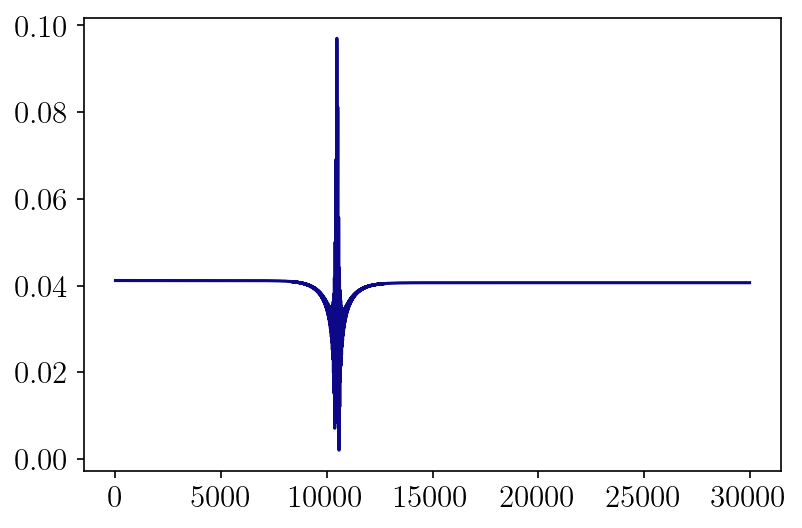

In [50]:
plt.plot(pas[0, :])

In [29]:
crossing_ind_avg

10483

In [68]:
crossing_ind_avg = 0

for i in range(1000):
    crossing_ind = pas[i, :].argmax()
    #crossing_ind = np.linalg.norm(rs[i, 0:500], axis=1).argmax()
    crossing_ind_avg += crossing_ind
    
crossing_ind_avg /= 1000
crossing_ind_avg = int(round(crossing_ind_avg))

In [69]:
np.linalg.norm(b_field_h(np.zeros(3)))

1.034760971025162e-08

In [70]:
b_min = sigma * b0x
#b_min = 1e10

'''
for i in range(1000):
    r_temp, b_temp = guiding_center(rs[i, crossing_ind_avg], vs[i, crossing_ind_avg], b_field, ms[i], qs[i])
    b_min_maybe = np.linalg.norm(b_temp)
    if b_min_maybe < b_min:
        b_min = b_min_maybe
'''

'\nfor i in range(1000):\n    r_temp, b_temp = guiding_center(rs[i, crossing_ind_avg], vs[i, crossing_ind_avg], b_field, ms[i], qs[i])\n    b_min_maybe = np.linalg.norm(b_temp)\n    if b_min_maybe < b_min:\n        b_min = b_min_maybe\n'

In [71]:
gca_points = np.zeros((1000, 2, 3))

for i in range(1000):
    r, gca_points[i, 0] = guiding_center(rs[i, 0], vs[i, 0], b_field_h, ms[i], qs[i])
    r, gca_points[i, 1] = guiding_center(rs[i, crossing_ind_avg * 2], vs[i, crossing_ind_avg * 2], b_field_h, ms[i], qs[i])

    #r, gca_points[i, 0] = guiding_center(rs[i, 0], vs[i, 0], b_field, ms[i], qs[i])
    #r, gca_points[i, 1] = guiding_center(rs[i, crossing_ind_avg * 2], vs[i, crossing_ind_avg * 2], b_field, ms[i], qs[i])

In [72]:
norm_mom_bs = b_min / np.linalg.norm(gca_points, axis=2)

In [73]:
sin_pas_start = np.sin(np.arccos(np.sum(vs[:, 0] * gca_points[:, 0], axis=1) / (np.linalg.norm(vs[:, 0], axis=1) * np.linalg.norm(gca_points[:, 0], axis=1))))

In [74]:
sin_pas_end = np.sin(np.arccos(np.sum(vs[:, crossing_ind_avg * 2] * gca_points[:, 1], axis=1) / (np.linalg.norm(vs[:, crossing_ind_avg * 2], axis=1) * np.linalg.norm(gca_points[:, 1], axis=1))))

In [75]:
mu_final

array([0.11819449, 0.11814396, 0.11809299, 0.11804157, 0.11798972,
       0.11793743, 0.1178847 , 0.11783155, 0.11777796, 0.11772394,
       0.1176695 , 0.11761464, 0.11755935, 0.11750364, 0.11744751,
       0.11739097, 0.11733401, 0.11727664, 0.11721886, 0.11716068,
       0.11710209, 0.11704309, 0.1169837 , 0.11692391, 0.11686372,
       0.11680313, 0.11674216, 0.1166808 , 0.11661904, 0.11655691,
       0.11649439, 0.11643149, 0.11636822, 0.11630456, 0.11624054,
       0.11617614, 0.11611138, 0.11604625, 0.11598076, 0.11591491,
       0.1158487 , 0.11578213, 0.11571521, 0.11564795, 0.11558033,
       0.11551236, 0.11544406, 0.11537541, 0.11530643, 0.11523711,
       0.11516746, 0.11509748, 0.11502717, 0.11495654, 0.11488558,
       0.11481431, 0.11474272, 0.11467081, 0.1145986 , 0.11452608,
       0.11445325, 0.11438012, 0.11430669, 0.11423296, 0.11415894,
       0.11408462, 0.11401002, 0.11393513, 0.11385996, 0.11378451,
       0.11370878, 0.11363278, 0.11355651, 0.11347996, 0.11340

In [76]:
mu_initial = 0.5 * norm_mom_bs[:, 0] * sin_pas_start**2

In [77]:
mu_final = 0.5 * norm_mom_bs[:, 1] * sin_pas_end**2

In [45]:
bms = a.b_mag()

In [47]:
np.degrees(np.arcsin(np.sqrt(bms[0, crossing_ind_avg] / bms[0, 0]) * np.sin(pas[0, 0])))

1.2754112514526004

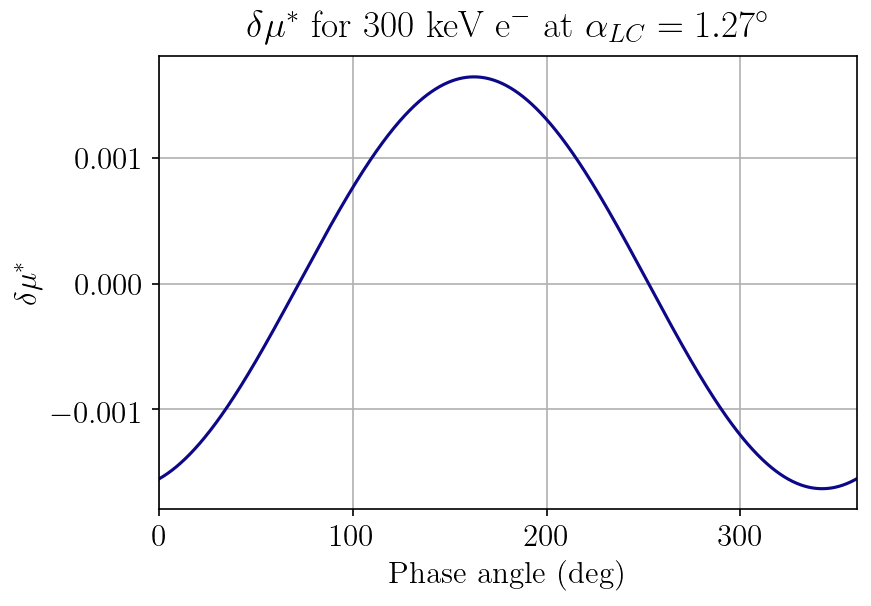

In [78]:
plt.plot(np.degrees(np.linspace(0, 2 * np.pi, 1000)), mu_final - mu_initial)
plt.title(r'$\delta\mu^*$ for $300$ keV e$^-$ at $\alpha_{LC}=1.27^\circ$')
plt.ylabel(r'$\delta\mu^*$')
plt.xlabel('Phase angle (deg)')
plt.xlim([0, 360])
plt.grid()
plt.show()

In [43]:
dmu = mu_final - mu_initial

In [44]:
A_numerical = (np.amax(dmu) - np.amin(dmu)) / 2

In [84]:
A_numerical = 0.000006 + 0.000006

In [45]:
D_aa_num = A_numerical**2 / (2 * T_alpha(np.radians(1.2716100390783267)) * np.sin(np.radians(1.2716100390783267))**2 * np.cos(np.radians(1.2716100390783267))**2)

In [46]:
1 / D_aa_num

1.4753402655109553

In [ ]:
np.save('300kev_we_dmu', dmu)

In [23]:
a.ke()

array([[ 300000.        ,  300401.2431239 ,  301565.32366853, ...,
         996414.41011992, 1008649.9394183 , 1022030.22652993],
       [ 300000.        ,  300395.32066023,  301554.06895773, ...,
         993047.99602117, 1004859.54068001, 1017932.85786834],
       [ 300000.        ,  300389.4042483 ,  301542.83739108, ...,
         989756.18616867, 1001098.2908787 , 1013820.01084721],
       ...,
       [ 300000.        ,  300413.1052685 ,  301587.90073594, ...,
        1003290.49673874, 1016244.78060263, 1030114.49086771],
       [ 300000.        ,  300407.17140488,  301576.60107704, ...,
         999834.93881151, 1012450.7434184 , 1026095.69245137],
       [ 300000.        ,  300401.2431239 ,  301565.32366853, ...,
         996414.41011992, 1008649.9394183 , 1022030.22652993]])

In [54]:
z1, z2 = zetas(b_field, 10)

In [59]:
E = 300e3
K = eV_to_J(E)
p = np.sqrt(K**2 / sp.c**2 + 2. * K * sp.m_e)

In [62]:
R_c = flc(b_field, rr[cs_ind], eps=1)

In [64]:
eps = p / (np.abs(-sp.e) * bm[cs_ind] * R_c)

In [66]:
A(eps, z1, z2, np.radians(1.2716100390783267))

0.00088460978478827

In [69]:
daas_young = D_aa(eps, z1, z2, np.linspace(0 + 1e-10, np.pi / 2 - 1e-10, 1000), T_alpha)

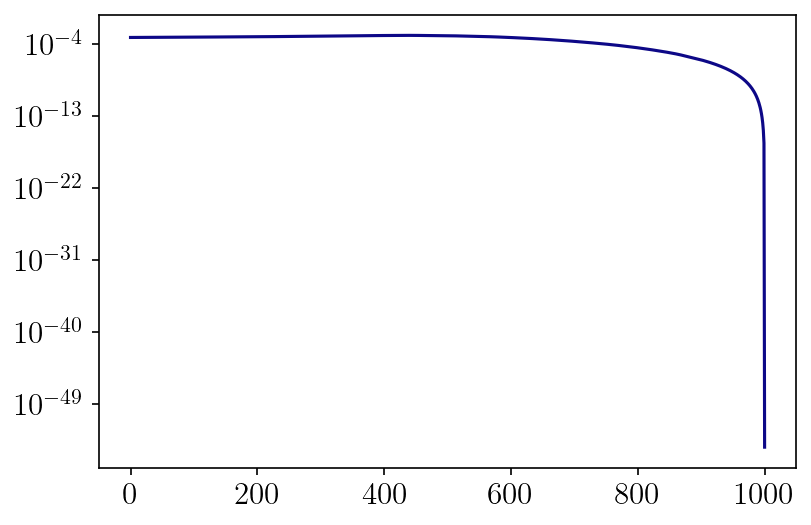

In [71]:
plt.semilogy(daas_young)

In [62]:
prior = moms[0, 0] * b_min * (1.60217662e-13 / 0.0001) / (sp.m_e * 98444701**2)

In [63]:
after = moms[0, crossing_ind_avg * 2] * b_min * (1.60217662e-13 / 0.0001) / (sp.m_e * 98444701**2)

In [66]:
after - prior

-7.457154478742833e-06